# Output diversification
Students: Irene Cantero (U151206) / Jian Chen (U150279)

The idea of this exercise is to diversify the outputs of the current ranking systems.

Content:
- Current state of the search engine
- Measures for the diversity score and coverage
- Post processing results after applying a custom algorithm made by us to increase the diversity score and coverage


In [3]:
from search_engine.search_engine import SearchEngine
import pandas as pd
import os
import warnings
import csv
import numpy as np
from sklearn.cluster import KMeans
import random
warnings.filterwarnings('ignore')

In [4]:
# Initialization of the search engine
search_engine = SearchEngine()

Collection time: 0.0


In [5]:
'''
Assignation of clusters for the documents using K-means.
"search_engine.query_results" is the database that contains the tweets to be returned by the ranking system. The reason of
its existance is because it is a simplified version of "search_engine.tweets", which contains all the columns of the
original tweets.
'''
def cluster_assignation(model):
    search_engine.query_results["cluster_label"] = np.zeros(len(search_engine.query_results))
    NUM_CLUSTERS = 3
    total_tokens=[]
    # Word embedding using Word2Vec for each tweet in the simplified database
    for tweet in search_engine.query_results["Tweet"]:
        tokens = []
        for word in tweet.split():
            try:
                tokens.append(model[word])
            except:
                pass
        tokens = np.mean(np.array(tokens), axis=0)
        if str(tokens) != 'nan':
            total_tokens.append(tokens)         
    # # K-means clustering
    kmeans = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans = kmeans.fit(total_tokens)
    labels = kmeans.predict(total_tokens)
    
    # Label assignation
    for k in range(len(labels)):
        search_engine.query_results["cluster_label"][k]=labels[k]

In [6]:
model = search_engine.ranking_system.w2v
cluster_assignation(model)

In [7]:
def get_sorted_dictionary(input_: dict) -> list:
    return list(dict(sorted(input_.items(), key=lambda item: item[1], reverse=True)).keys())

def compute_cluster_dominance(results: pd.DataFrame, num_clusters: int) -> dict:
    count_clusters = {}
    for i in range(num_clusters):
        count_clusters[i]=0
    for tweet in range(len(results)):
        results.columns
        count_clusters[results["cluster_label"][tweet]]+=1
    
    total_tweets = sum(count_clusters.values())
    for i in range(num_clusters):
        count_clusters[i] = count_clusters[i]/total_tweets
    
    return count_clusters

def coverage_score(clusters: dict) -> float:
    coverage = 1.0
    for cluster in clusters:
        if clusters[cluster] == 0:
            coverage -= 1/len(clusters)
        return coverage
def diversity_score(clusters: dict) -> float:
    difference = 0.0
    for cluster in clusters:
        difference += np.abs(1/len(clusters) - clusters[cluster])
    return 1 - difference

In [8]:
# given a cluster, finds the first tweet belonging to that cluster, and returns it
def get_first_result_of_cluster(results: pd.DataFrame, cluster: int) -> pd.Series:
    first_result = results.query(f"cluster_label == {cluster}")
    return first_result.iloc[0]

# returns the dominant clusters presence
def compute_dominance(results: pd.DataFrame, num_clusters: int) -> dict:
    cluster_dominance=compute_cluster_dominance(results, num_clusters)
    sorted_cluster_dominance = get_sorted_dictionary(cluster_dominance)
    return sorted_cluster_dominance

# returns if the score passed certain threshold
def cluster_diversity(clusters: dict) -> bool:
    threshold = 0.9
    score = diversity_score(clusters)
    return score > threshold

# core function 
def diversity_increaser(results: pd.DataFrame, num_clusters:int , num_iter:int) -> None:
    minimum_length = 20
    # We cannot add tweets from other clusters, if the tweets are not related with the query
    if len(results) <= minimum_length:
        return
    
    # getting most and least dominant clusters
    sorted_cluster_dominance = compute_dominance(results.head(20), num_clusters)
    
    most_dominant = sorted_cluster_dominance[0]
    least_dominant = sorted_cluster_dominance[num_clusters-1]
    
    # getting index of the tweets that appears in the ranking and belongs to the most dominant cluster.
    most_dominant_results = results.head(20).query(f"cluster_label == {most_dominant}")
    most_dominant_results_index = list(most_dominant_results.index)

    # the for loop gets the most dominant document, generates a random index number, and replace the tweet with that index
    # by the top 1 of the least dominant cluster.
    for i in range(num_iter):
        for tweet in range(len(most_dominant_results)):
            # getting a random index of the dominant cluster
            random_position = random.randint(0, len(most_dominant_results)-1) 
            index_to_replace = most_dominant_results_index[random_position]
            # replace the tweet with the random index, by the top 1 of the least dominant cluster
            results.iloc[index_to_replace] = get_first_result_of_cluster(results, least_dominant)
            
            # update the state by looking how dominant are each cluster after the replace.
            sorted_cluster_dominance = compute_dominance(results.head(20), num_clusters)
            new_dominant = sorted_cluster_dominance[0]
            new_least_dominant = sorted_cluster_dominance[num_clusters-1]
            
            if least_dominant != new_least_dominant:
                least_dominant = new_least_dominant
                
            if most_dominant != new_dominant:
                most_dominant = new_dominant
                break
        # if the diversity score is high enough, break the loop to not continue iterating
        if cluster_diversity(sorted_cluster_dominance):
            break


This is how we have the search engine right now. As we can see here, the top 20, is returning results from the cluster 0 and cluster 2, but nothing for 1 and 3. Therefore, we should try to find a way to include these cluster at least in the top 20. 

The diversity score has been defined by us, and it is computed with the following formula: 

\begin{equation*}
score  = 1 - \sum_{k=1}^N  |\frac{1}{N} - dominance_k|
\end{equation*} where N is number of clusters and dominance is the cluster presence in the suggested ranking list.

Below we provide an example:

In [9]:
print("Insert your query:\n")
query = input()
results = search_engine.run(query).query("score > 0")
results

Insert your query:

joe biden


,Tweet,Username,Date,Hashtags,Likes,Retweets,Replies,Url,cluster_label,score
0,“Why did you vote for Joe Biden?”,COL Joe #StopTheSteal,Mon Dec 07 23:19:04 +0000 2020,[],11,2,2,https://twitter.com/i/web/status/1336087861473...,0.0,0.840332
1,Joe Biden won Georgia again.,coca 💙 Mask up and Social distance 😷,Mon Dec 07 17:53:16 +0000 2020,[],10,3,0,https://twitter.com/i/web/status/1336005873190...,0.0,0.770349
2,Joe Biden just won Georgia AGAIN,Palmer Report,Mon Dec 07 21:31:02 +0000 2020,[],465,86,23,https://twitter.com/i/web/status/1336060674871...,0.0,0.770349
3,We all know who won. And it wasn't Joe Biden....,GrrrGraphics Cartoons,Mon Dec 07 14:52:11 +0000 2020,[],963,368,25,https://twitter.com/i/web/status/1335960302144...,0.0,0.726675
4,What is joe Biden fighting for?,djhutch,Mon Dec 07 21:27:17 +0000 2020,[],35,3,35,https://twitter.com/i/web/status/1336059731262...,0.0,0.651067
...,...,...,...,...,...,...,...,...,...,...
387,Tom Perez is being considered for Joe Biden’s ...,Thia is with ...😏✌️💋🔥,Mon Dec 07 00:59:54 +0000 2020,[],987,182,62,https://twitter.com/i/web/status/1335750852615...,0.0,0.147919
388,One of the side effects of Joe Biden’s Dementi...,This Is MAGA Country 🇺🇸,Fri Dec 04 04:53:41 +0000 2020,[],607,554,58,https://twitter.com/i/web/status/1334722519224...,0.0,0.146982
389,@BreakingBrown Origins of BLM Explained &amp; ...,Antonio Moore,Mon Dec 07 23:18:37 +0000 2020,[],3,1,0,https://twitter.com/i/web/status/1336087749535...,0.0,0.146281
390,@NathanLands @Jim_Jordan Socialism ?\nNo.\nCom...,Dan Roley,Mon Dec 07 23:16:38 +0000 2020,[],1,1,0,https://twitter.com/i/web/status/1336087251860...,0.0,0.143445


The output below shows the dominance of each cluster, the diversity score, the most dominant cluster and the ranking coverage that is computed by doing:
\begin{equation*}
score  = 1 - \sum_{k=1}^M  \frac{1}{N}
\end{equation*}
Where M is the number of clusters appearing in the top 20 and N is the total number of clusters.

In [10]:
results_clusters = compute_cluster_dominance(results.head(20), 3)
dominant_clusters = get_sorted_dictionary(results_clusters)
score = diversity_score(results_clusters)
cov_score = coverage_score(results_clusters)
print(f"Clusters and percentage of dominance{results_clusters}")
print(f"Diversity score of original ranking: {score}")
print(f"Cluster dominance: {dominant_clusters[0]}")
print(f"Ranking coverage: {cov_score}")

Clusters and percentage of dominance{0: 0.7, 1: 0.05, 2: 0.25}
Diversity score of original ranking: 0.26666666666666683
Cluster dominance: 0
Ranking coverage: 1.0


Here we start with the preprocessing part of the current result in order to increase the diversity score and the ranking coverage. The goal is to increase the diversity score and ranking coverage, while preserving a decent score of the overall ranking. To do so, we perform the following steps:
- Get the most dominant cluster and the least dominant
- Generate a random index number within the results belonging to the dominant cluster to replace it.
- Replace it for the top 1 of the least dominant cluster, to maintain a good score.
- Repeat the process until passing certain threshold or after N iterations

This is the results after the postprocessing. As you can see the diversity score has increased significantly, and the coverage is also maximized.

In [11]:
diversity_increaser(results, 3, 100)
results_clusters = compute_cluster_dominance(results.head(20), 3)
dominant_clusters = get_sorted_dictionary(results_clusters)
score = diversity_score(results_clusters)
cov_score = coverage_score(results_clusters)

print(f"Clusters and percentage of dominance{results_clusters}")
print(f"Diversity score of the new ranking: {score}")
print(f"Cluster dominance: {dominant_clusters[0]}")
print(f"Ranking coverage: {cov_score}")

Clusters and percentage of dominance{0: 0.35, 1: 0.3, 2: 0.35}
Diversity score of the new ranking: 0.9333333333333333
Cluster dominance: 0
Ranking coverage: 1.0


In [12]:
results

,Tweet,Username,Date,Hashtags,Likes,Retweets,Replies,Url,cluster_label,score
0,Joe Biden won Georgia again.,coca 💙 Mask up and Social distance 😷,Mon Dec 07 17:53:16 +0000 2020,[],10,3,0,https://twitter.com/i/web/status/1336005873190...,0.0,0.770349
1,Joe Biden won Georgia again.,coca 💙 Mask up and Social distance 😷,Mon Dec 07 17:53:16 +0000 2020,[],10,3,0,https://twitter.com/i/web/status/1336005873190...,0.0,0.770349
2,I will NEVER call Joe Biden my President!!,Brigitte Gabriel,Sun Dec 06 22:42:30 +0000 2020,[],11089,1707,644,https://twitter.com/i/web/status/1335716274387...,1.0,0.519053
3,Joe Biden should concede.,Grifter-Elect Roz al Gulag 🇺🇸,Mon Dec 07 22:45:28 +0000 2020,[],289,20,12,https://twitter.com/i/web/status/1336079408264...,2.0,0.551506
4,I will NEVER call Joe Biden my President!!,Brigitte Gabriel,Sun Dec 06 22:42:30 +0000 2020,[],11089,1707,644,https://twitter.com/i/web/status/1335716274387...,1.0,0.519053
...,...,...,...,...,...,...,...,...,...,...
387,Tom Perez is being considered for Joe Biden’s ...,Thia is with ...😏✌️💋🔥,Mon Dec 07 00:59:54 +0000 2020,[],987,182,62,https://twitter.com/i/web/status/1335750852615...,0.0,0.147919
388,One of the side effects of Joe Biden’s Dementi...,This Is MAGA Country 🇺🇸,Fri Dec 04 04:53:41 +0000 2020,[],607,554,58,https://twitter.com/i/web/status/1334722519224...,0.0,0.146982
389,@BreakingBrown Origins of BLM Explained &amp; ...,Antonio Moore,Mon Dec 07 23:18:37 +0000 2020,[],3,1,0,https://twitter.com/i/web/status/1336087749535...,0.0,0.146281
390,@NathanLands @Jim_Jordan Socialism ?\nNo.\nCom...,Dan Roley,Mon Dec 07 23:16:38 +0000 2020,[],1,1,0,https://twitter.com/i/web/status/1336087251860...,0.0,0.143445



joe biden won elections

result length: 89
BEFORE Clusters and percentage of dominance{0: 0.6, 1: 0.05, 2: 0.35}
BEFORE Diversity score of original ranking: 0.43333333333333335
BEFORE Cluster dominance: 0
BEFORE Ranking coverage: 1.0


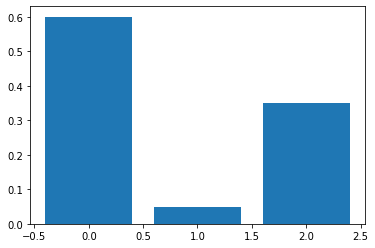

AFTER Clusters and percentage of dominance{0: 0.35, 1: 0.3, 2: 0.35}
AFTER Diversity score of original ranking: 0.9333333333333333
AFTER Cluster dominance: 0
AFTER Ranking coverage: 1.0


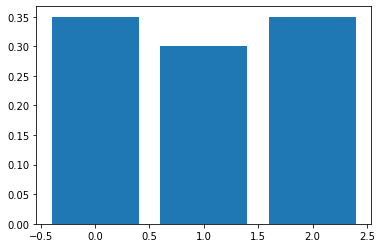


donald trump is the president

result length: 64
BEFORE Clusters and percentage of dominance{0: 0.55, 1: 0.05, 2: 0.4}
BEFORE Diversity score of original ranking: 0.43333333333333335
BEFORE Cluster dominance: 0
BEFORE Ranking coverage: 1.0


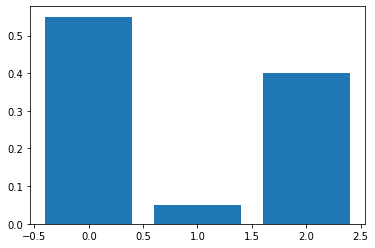

AFTER Clusters and percentage of dominance{0: 0.25, 1: 0.35, 2: 0.4}
AFTER Diversity score of original ranking: 0.8333333333333333
AFTER Cluster dominance: 2
AFTER Ranking coverage: 1.0


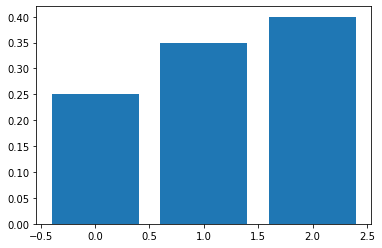


elections are a fraud

result length: 299
BEFORE Clusters and percentage of dominance{0: 0.4, 1: 0.05, 2: 0.55}
BEFORE Diversity score of original ranking: 0.43333333333333324
BEFORE Cluster dominance: 2
BEFORE Ranking coverage: 1.0


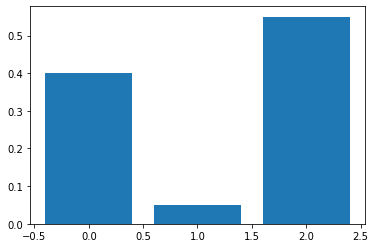

AFTER Clusters and percentage of dominance{0: 0.4, 1: 0.25, 2: 0.35}
AFTER Diversity score of original ranking: 0.8333333333333333
AFTER Cluster dominance: 0
AFTER Ranking coverage: 1.0


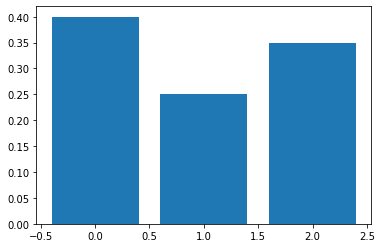

In [16]:
import matplotlib.pyplot as plt
queries = ["joe biden won elections", "donald trump is the president", "elections are a fraud"]

try:
    os.remove('other-outputs/RQ2a_no_diversity.tsv')
except:
    pass

try:
    os.remove('other-outputs/RQ2a_with_diversity.tsv')
except:
    pass

# Setting the header of the TSV files
RQ1 = open('other-outputs/RQ2a_no_diveristy.tsv', 'a+')
RQ1.write("\tTweet\tUsername\tDate\tHashtags\tLikes\tRetweets\tReplies\tUrl\tScore\n")
RQ1.close()

RQ1 = open('other-outputs/RQ2a_with_diveristy.tsv', 'a+')
RQ1.write("\tTweet\tUsername\tDate\tHashtags\tLikes\tRetweets\tReplies\tUrl\tScore\n")
RQ1.close()

for query in queries:
    # printing the query and putting in the tsv files
    print("\n"+query+"\n")
    RQ1 = open('other-outputs/RQ2a_no_diveristy.tsv', 'a+')
    RQ1.write(f"QUERY\t{query}\n")
    RQ1.close()
    
    RQ1 = open('other-outputs/RQ2a_with_diveristy.tsv', 'a+')
    RQ1.write(f"QUERY\t{query}\n")
    RQ1.close()
    
    # Getting the stats of the search results without applying our diversification algorithm.
    results = search_engine.run(query).query("score>0")
    print("result length: "+ str(len(results)))
    results_clusters = compute_cluster_dominance(results.head(20), 3)
    dominant_clusters = get_sorted_dictionary(results_clusters)
    score = diversity_score(results_clusters)
    cov_score = coverage_score(results_clusters)
    
    print(f"BEFORE Clusters and percentage of dominance{results_clusters}")
    print(f"BEFORE Diversity score of original ranking: {score}")
    print(f"BEFORE Cluster dominance: {dominant_clusters[0]}")
    print(f"BEFORE Ranking coverage: {cov_score}")
    plt.figure()
    plt.bar(list(results_clusters.keys())[:5], height=list(results_clusters.values())[:5])
    plt.show()
    # saving the results in the tsv file
    results.head(20).replace('\n',' ', regex=True).to_csv(path_or_buf='other-outputs/RQ2a_no_diveristy.tsv', sep='\t', header=False, mode = 'a')
    
    #Apply the diversification algorithm
    diversity_increaser(results, 3, 500)
    
    # Repeat the same steps above
    results_clusters = compute_cluster_dominance(results.head(20), 3)
    dominant_clusters = get_sorted_dictionary(results_clusters)
    score = diversity_score(results_clusters)
    cov_score = coverage_score(results_clusters)
    
    print(f"AFTER Clusters and percentage of dominance{results_clusters}")
    print(f"AFTER Diversity score of original ranking: {score}")
    print(f"AFTER Cluster dominance: {dominant_clusters[0]}")
    print(f"AFTER Ranking coverage: {cov_score}")
    plt.figure()
    plt.bar(list(results_clusters.keys())[:5], height=list(results_clusters.values())[:5])
    plt.show()
    
    results.head(20).replace('\n',' ', regex=True).to_csv(path_or_buf='other-outputs/RQ2a_with_diveristy.tsv', sep='\t', header=False, mode = 'a')